# Inversion of sea surface currents from satellite-derived SST-SSH synergies with 4DVarNets

This notebook presents the evaluation of the sea surface currents (SSC) reconstruction based on the 4DVarNet approach ([Fablet et al., 2022](https://arxiv.org/abs/2211.13059)).

It is structured as follow:

1. Methodology
2. Reading of reference and reconstructed SSC fields
3. Evaluating the reconstructed SSC field
4. Visualisation

We will use the following modules in this notebook:

In [1]:
import pandas as pd
import xarray as xr

from src.metrics import psd_based_scores, rmse_based_scores, var_based_scores
from src.plot import plot_psd_score

## 1. Methodology

The evaluations are based on the methods & metrics used in the [_2020a SSH mapping NATL60_](https://github.com/ocean-data-challenges/2020a_SSH_mapping_NATL60#baseline-and-evaluation) ocean data challenge. It includes a statistical and spectral analysis between each reconstruction and the ground truth.

The compared reconstructions are based on U-Net and 4DVarNet (see the research paper).

### Statistical analysis

The reconstruction is evaluated with the following metric, given a time $t$:

$$
    RMSE_{\text{ref}, \text{rec}}(t) =
        1 - \frac{RMSE(\text{rec}(t))}{RMS(\text{ref}(t))}
$$

Where $RMSE$ is the root mean square error, $RMS$ is the root mean square and $\text{ref}(t)$ (resp. $\text{rec}(t)$) is the reference (resp. reconstructed) SSC field at time $t$.

The metric $RMSE_{\text{ref}, \text{rec}}$ is calculated for each time $t_0, t_1, ..., t_n$. Then, we deduce the mean score $\mu$ and the standard deviation $\sigma$. This latter gives an insight on the temporal stability of the reconstruction.

In addition to the previous metric, the reconstruction performance is also 
evaluated in terms of explained variance:

- $\tau_{u,v}$ : explained variance of the reconstructed SSC
- $\tau_{\text{vort}}$ : explained variance of the vorticity of the
    reconstructed SSC
- $\tau_{\text{div}}$ : explained variance of the divergence of the
    reconstructed SSC
- $\tau_{\text{strain}}$ : explained variance of the strain of the reconstructed
    SSC

### Spectral analysis

The metric used here is the power spectral density, based on the wavenumber frequency. It is defined as follow:

$$
    PSD_{\text{ref}, \text{rec}} = 1 - \frac{PSD(\text{rec} - \text{ref})}{PSD(\text{ref})}
$$

From this spectral analysis, the following scores can be derived:

- $\lambda_t$ : the minimum time scale resolved in days for the SSH reconstruction
- $\lambda_x$ : the minimum spatial scale resolved in degrees for the SSH reconstruction
- $\lambda_{t,u}$ and $\lambda_{t,v}$ : same as $\lambda_t$ but for the zonal and meridional velocities
- $\lambda_{x,u}$ and $\lambda_{x,v}$ : same as $\lambda_x$ but for the zonal and meridional velocities

## 2. Reading of reference and reconstructed SSC fields

The reconstructed data are located in the `./results/` directory in netCDF4 format. The variables contained in these data are the sea surface height (SSH), the sea surface temperature (SST), the zonal velocity $u$ et the meridional velocity $v$.

Note that both data are already on the same grid.

In [2]:
# Paths to the netCDF files
paths = {
    'true_ssh': 'results/true-ssh.nc',
    'unet_ssh': 'results/unet-ssh.nc',
    'unet_ssh_sst': 'results/unet-ssh-sst.nc',
    '4dvarnet_ssh': 'results/4dvarnet-ssh.nc',
    '4dvarnet_ssh_sst': 'results/4dvarnet-ssh-sst.nc',
}

In [3]:
# Retrieving reference data
ref = xr.open_dataset(paths['true_ssh'])
ref

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200, feat: 1)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
  * feat     (feat) int64 0
Data variables:
    ssh      (time, lat, lon) float64 ...
    sst      (time, feat, lat, lon) float32 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

In [4]:
# Retrieving U-Net reconstructions
rec_unet_ssh = xr.open_dataset(paths['unet_ssh'])
rec_unet_ssh_sst = xr.open_dataset(paths['unet_ssh_sst'])

rec_unet_ssh

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
Data variables:
    ssh      (time, lat, lon) float64 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

In [5]:
rec_unet_ssh_sst

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200, feat: 1)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
  * feat     (feat) int64 0
Data variables:
    ssh      (time, lat, lon) float64 ...
    sst      (time, feat, lat, lon) float32 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

In [6]:
# Retrieving 4DVarNet reconstructions
rec_4dvarnet_ssh = xr.open_dataset(paths['4dvarnet_ssh'])
rec_4dvarnet_ssh_sst = xr.open_dataset(paths['4dvarnet_ssh_sst'])

rec_4dvarnet_ssh

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
Data variables:
    ssh      (time, lat, lon) float64 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

In [7]:
rec_4dvarnet_ssh_sst

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200, feat: 1)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
  * feat     (feat) int64 0
Data variables:
    ssh      (time, lat, lon) float64 ...
    sst      (time, feat, lat, lon) float32 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

## 3. Evaluating the reconstructed SSC field

Evaluating the reconstructed SSC field requires to compute the scores of the SSH, $u$ and $v$ of each field.

In [8]:
scores_unet_ssh, scores_unet_ssh_sst = {}, {}
scores_4dvarnet_ssh, scores_4dvarnet_ssh_sst = {}, {}

### A. Reconstructions without SST

**U-Net**.

In [9]:
# SSH scores
rmse_A, rmse_mu, rmse_sigma = rmse_based_scores(rec_unet_ssh.ssh, ref.ssh)
tau_uv, tau_vort, tau_div, tau_strain = var_based_scores(rec_unet_ssh, ref)
psd_unet_ssh, lambda_x, lambda_t = psd_based_scores(rec_unet_ssh.ssh, ref.ssh)

scores_unet_ssh['µ'] = rmse_mu
scores_unet_ssh['σ'] = rmse_sigma
scores_unet_ssh['λ_x'] = lambda_x
scores_unet_ssh['λ_t'] = lambda_t

# u scores
lambda_xu, lambda_tu = psd_based_scores(rec_unet_ssh.u, ref.u)[1:]

scores_unet_ssh['λ_{x,u}'] = lambda_xu
scores_unet_ssh['λ_{t,u}'] = lambda_tu

# v scores
lambda_xv, lambda_tv = psd_based_scores(rec_unet_ssh.v, ref.v)[1:]

scores_unet_ssh['λ_{x,v}'] = lambda_xv
scores_unet_ssh['λ_{t,v}'] = lambda_tv

# Append the explainable variances to the scores
scores_unet_ssh['τ_{u,v}'] = tau_uv
scores_unet_ssh['τ_vort'] = tau_vort
scores_unet_ssh['τ_div'] = tau_div
scores_unet_ssh['τ_strain'] = tau_strain

**4DVarNet**.

In [10]:
# SSH scores
rmse_A, rmse_mu, rmse_sigma = rmse_based_scores(rec_4dvarnet_ssh.ssh, ref.ssh)
tau_uv, tau_vort, tau_div, tau_strain = var_based_scores(rec_4dvarnet_ssh, ref)
psd_4dvarnet_ssh, lambda_x, lambda_t = psd_based_scores(rec_4dvarnet_ssh.ssh, ref.ssh)

scores_4dvarnet_ssh['µ'] = rmse_mu
scores_4dvarnet_ssh['σ'] = rmse_sigma
scores_4dvarnet_ssh['λ_x'] = lambda_x
scores_4dvarnet_ssh['λ_t'] = lambda_t

# u scores
lambda_xu, lambda_tu = psd_based_scores(rec_4dvarnet_ssh.u, ref.u)[1:]

scores_4dvarnet_ssh['λ_{x,u}'] = lambda_xu
scores_4dvarnet_ssh['λ_{t,u}'] = lambda_tu

# v scores
lambda_xv, lambda_tv = psd_based_scores(rec_4dvarnet_ssh.v, ref.v)[1:]

scores_4dvarnet_ssh['λ_{x,v}'] = lambda_xv
scores_4dvarnet_ssh['λ_{t,v}'] = lambda_tv

# Append the explainable variances to the scores
scores_4dvarnet_ssh['τ_{u,v}'] = tau_uv
scores_4dvarnet_ssh['τ_vort'] = tau_vort
scores_4dvarnet_ssh['τ_div'] = tau_div
scores_4dvarnet_ssh['τ_strain'] = tau_strain

### B. Reconstruction with SST

**U-Net**.

In [11]:
# SSH scores
rmse_A, rmse_mu, rmse_sigma = rmse_based_scores(rec_unet_ssh_sst.ssh, ref.ssh)
tau_uv, tau_vort, tau_div, tau_strain = var_based_scores(rec_unet_ssh_sst, ref)
psd_unet_ssh_sst, lambda_x, lambda_t = psd_based_scores(rec_unet_ssh_sst.ssh, ref.ssh)

scores_unet_ssh_sst['µ'] = rmse_mu
scores_unet_ssh_sst['σ'] = rmse_sigma
scores_unet_ssh_sst['λ_x'] = lambda_x
scores_unet_ssh_sst['λ_t'] = lambda_t

# u scores
lambda_xu, lambda_tu = psd_based_scores(rec_unet_ssh_sst.u, ref.u)[1:]

scores_unet_ssh_sst['λ_{x,u}'] = lambda_xu
scores_unet_ssh_sst['λ_{t,u}'] = lambda_tu

# v scores
lambda_xv, lambda_tv = psd_based_scores(rec_unet_ssh_sst.v, ref.v)[1:]

scores_unet_ssh_sst['λ_{x,v}'] = lambda_xv
scores_unet_ssh_sst['λ_{t,v}'] = lambda_tv

# Append the explainable variances to the scores
scores_unet_ssh_sst['τ_{u,v}'] = tau_uv
scores_unet_ssh_sst['τ_vort'] = tau_vort
scores_unet_ssh_sst['τ_div'] = tau_div
scores_unet_ssh_sst['τ_strain'] = tau_strain

**4DVarNet**.

In [12]:
# SSH scores
rmse_A, rmse_mu, rmse_sigma = rmse_based_scores(rec_4dvarnet_ssh_sst.ssh, ref.ssh)
tau_uv, tau_vort, tau_div, tau_strain = var_based_scores(rec_4dvarnet_ssh_sst, ref)
psd_4dvarnet_ssh_sst, lambda_x, lambda_t = psd_based_scores(rec_4dvarnet_ssh_sst.ssh, ref.ssh)

scores_4dvarnet_ssh_sst['µ'] = rmse_mu
scores_4dvarnet_ssh_sst['σ'] = rmse_sigma
scores_4dvarnet_ssh_sst['λ_x'] = lambda_x
scores_4dvarnet_ssh_sst['λ_t'] = lambda_t

# u scores
lambda_xu, lambda_tu = psd_based_scores(rec_4dvarnet_ssh_sst.u, ref.u)[1:]

scores_4dvarnet_ssh_sst['λ_{x,u}'] = lambda_xu
scores_4dvarnet_ssh_sst['λ_{t,u}'] = lambda_tu

# v scores
lambda_xv, lambda_tv = psd_based_scores(rec_4dvarnet_ssh_sst.v, ref.v)[1:]

scores_4dvarnet_ssh_sst['λ_{x,v}'] = lambda_xv
scores_4dvarnet_ssh_sst['λ_{t,v}'] = lambda_tv

# Append the explainable variances to the scores
scores_4dvarnet_ssh_sst['τ_{u,v}'] = tau_uv
scores_4dvarnet_ssh_sst['τ_vort'] = tau_vort
scores_4dvarnet_ssh_sst['τ_div'] = tau_div
scores_4dvarnet_ssh_sst['τ_strain'] = tau_strain

### C. Comparison between the reconstructions

We can now compare the scores from these two experiments:

In [13]:
# Print the scores
pd.DataFrame(
    data=[
        scores_unet_ssh, scores_unet_ssh_sst,
        scores_4dvarnet_ssh, scores_4dvarnet_ssh_sst,
    ],
    index=[
        'U-Net SSH only', 'U-Net SSH-SST',
        '4DVarNet SSH only', '4DVarNet SSH-SST',
    ],
).T

,U-Net SSH only,U-Net SSH-SST,4DVarNet SSH only,4DVarNet SSH-SST
µ,0.93268,0.94595,0.95835,0.96669
σ,0.00979,0.00882,0.00958,0.00610
λ_x,1.18035,0.87269,0.66325,0.72957
λ_t,10.24200,4.08276,5.12510,35.80565
"λ_{x,u}",1.36937,1.30577,0.88495,0.81065
"λ_{t,u}",9.18823,3.99081,4.20627,2.71561
"λ_{x,v}",1.20209,0.88752,0.67487,0.62226
"λ_{t,v}",10.18705,4.21142,5.65544,2.51652
"τ_{u,v}",89.03774,92.66992,93.97371,97.15594
τ_vort,71.99716,79.85851,85.68813,91.14695


## 4. Visualisation

PSD comparisons between U-Net SSH only and 4DVarNet SSH only:

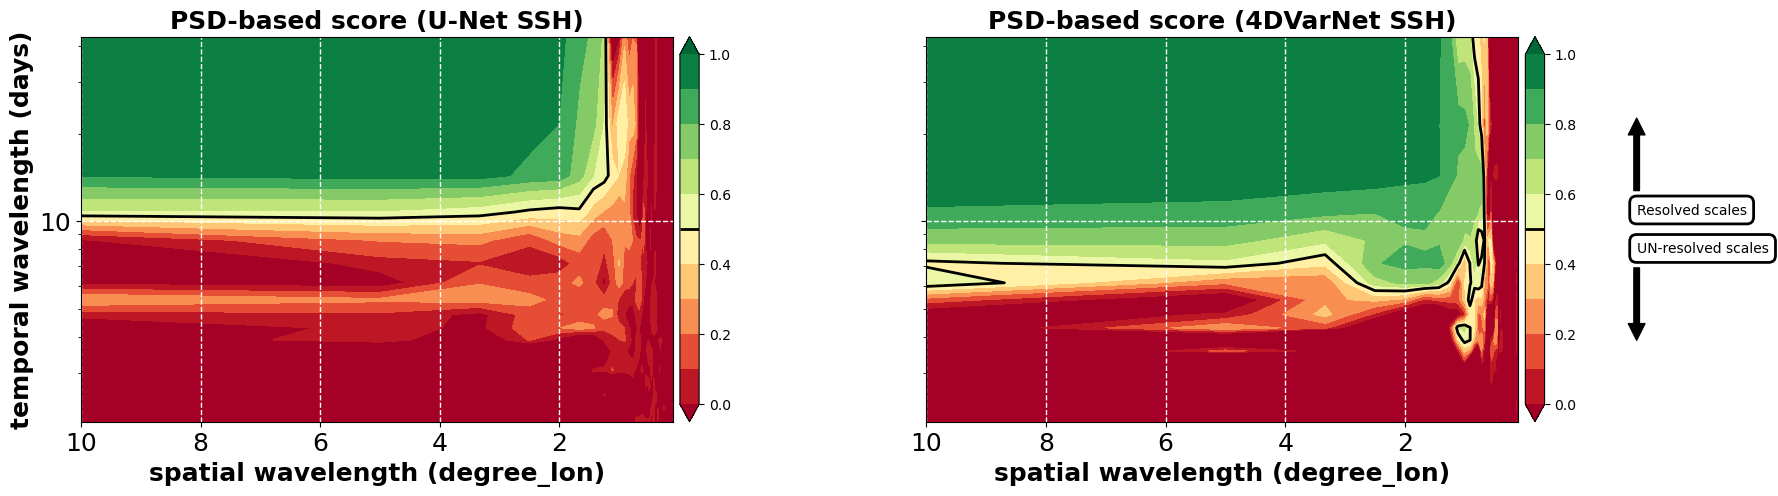

In [14]:
psd_concat = xr.concat((psd_unet_ssh, psd_4dvarnet_ssh), dim='experiment')
psd_concat['experiment'] = ['U-Net SSH', '4DVarNet SSH']

plot_psd_score(psd_concat)

PSD comparisons between U-Net SSH-SST and 4DVarNet SSH-SST:

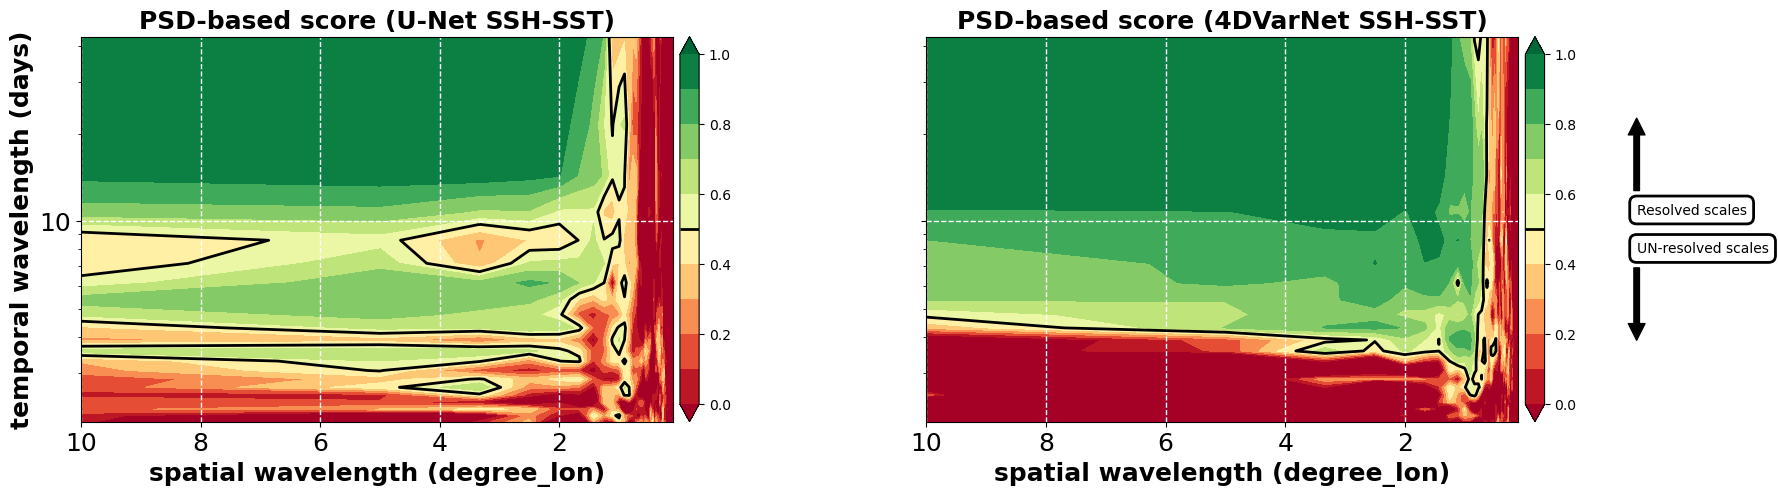

In [15]:
psd_concat = xr.concat((psd_unet_ssh_sst, psd_4dvarnet_ssh_sst), dim='experiment')
psd_concat['experiment'] = ['U-Net SSH-SST', '4DVarNet SSH-SST']

plot_psd_score(psd_concat)